## Setup
Import relevant libraries and read original data

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing, svm
import sklearn.cross_validation as cross
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import sklearn.metrics as metrics

c:\program files\python35\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
fraud_data = pandas.read_csv('fraud_prep.csv.gz')

## Support functions and constants

In [3]:
#constants
RANDOM_SEED = 42
TEST_SPLIT = 0.2
TOL = 1e-5
MAX_ITER = 1e5

## Data exploration

In [4]:
#How many rows of data are available?
len(fraud_data)

284807

In [5]:
#What does it look like at first glance?
fraud_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
#Is there missing data?
nan_count = 0
for c in fraud_data.columns:
    nan_count += sum(fraud_data[c].isnull())
print('The DataFrame contains',nan_count,'null values')

The DataFrame contains 0 null values


In [7]:
#What are the ranges in each column?
for c in fraud_data.columns:
    print(c)
    print(fraud_data.loc[:,c].describe(),end='\n\n')

Time
count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

V1
count    2.848070e+05
mean     1.165980e-15
std      1.958696e+00
min     -5.640751e+01
25%     -9.203734e-01
50%      1.810880e-02
75%      1.315642e+00
max      2.454930e+00
Name: V1, dtype: float64

V2
count    2.848070e+05
mean     3.416908e-16
std      1.651309e+00
min     -7.271573e+01
25%     -5.985499e-01
50%      6.548556e-02
75%      8.037239e-01
max      2.205773e+01
Name: V2, dtype: float64

V3
count    2.848070e+05
mean    -1.373150e-15
std      1.516255e+00
min     -4.832559e+01
25%     -8.903648e-01
50%      1.798463e-01
75%      1.027196e+00
max      9.382558e+00
Name: V3, dtype: float64

V4
count    2.848070e+05
mean     2.086869e-15
std      1.415869e+00
min     -5.683171e+00
25%     -8.486401e-01
50%     -1.984653e-02
75%      7.433413e-01
max      1.

All variables _V?_ are scaled to a mean close to zero and standard deviation close to 1, so not much more to do there. There's no reason to assume any of them wouldn't be relevant beforehand.

Columns _Time_ and _Amount_ have the original values, but may also help as predictors - fraudulent buyers might for example have different behaviors for different transaction amounts. One potentially interesting use for _Time_ would be binning transactions into times of the day.

Another important hint about the data is how imbalanced it is towards the 0 Class (assumed to be non-fraud). We'll avoid accuracy as a performance measure and check if over/undersampling is necessary after looking at other performance measures.

In [8]:
print('Only {:.3f}'.format(100*sum(fraud_data['Class'])/sum(fraud_data['Class'].notnull())),'% of data samples are classified into the 1 Class')

Only 0.173 % of data samples are classified into the 1 Class


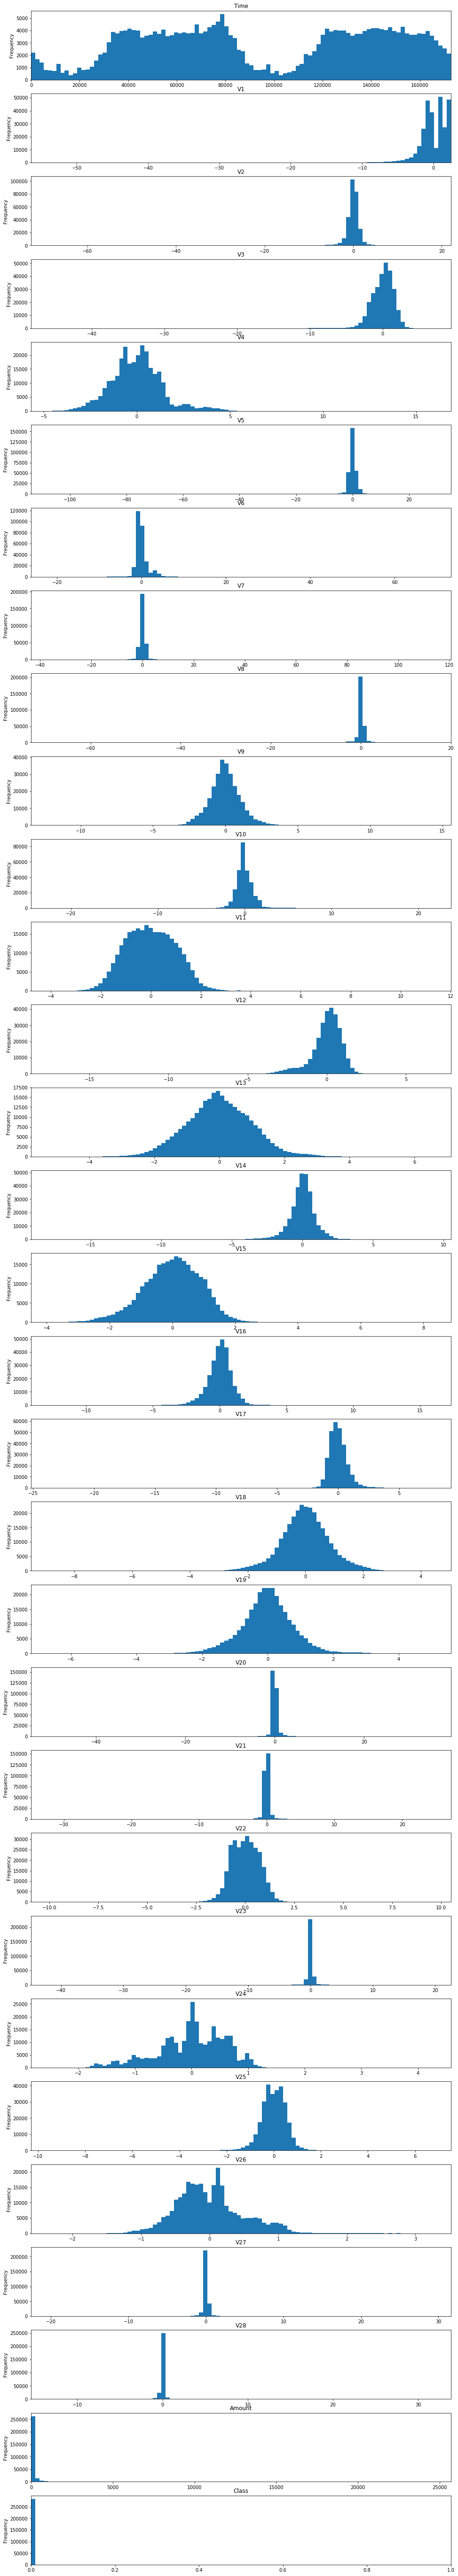

In [9]:
#What is the distribution of each variable?
fig, axes = plt.subplots(nrows=len(fraud_data.columns), ncols=1)
for i, c in enumerate(fraud_data.columns):
    fraud_data[c].plot(kind='hist', figsize=(16, 100), title=c,
                       ax=axes[i], bins=100,xlim=(fraud_data[c].min(),fraud_data[c].max()))

The charts above help make clear the presence of samples in each variable series that could be considered outliers. However without knowing what each feature represents, it is unwise to decide for removing outliers - it could have undesired effects. Outliers can after all be powerful predictors of frauds. This may also be a good hint for using **decision trees** over **logistic regression**, as the former tend to behave better with outliers.

One thing that can be noted in the chart for _Time_ above, is that there are two clear cycles of transactions, such as could be expected, for example, for the transaction volume along the day. From now on, it will be assumed then that the _Time_ column is in _seconds_, meaning the data covers a few seconds short of 2 full days of transactions. (The valleys of transaction volume most likely representing late night / early morning)

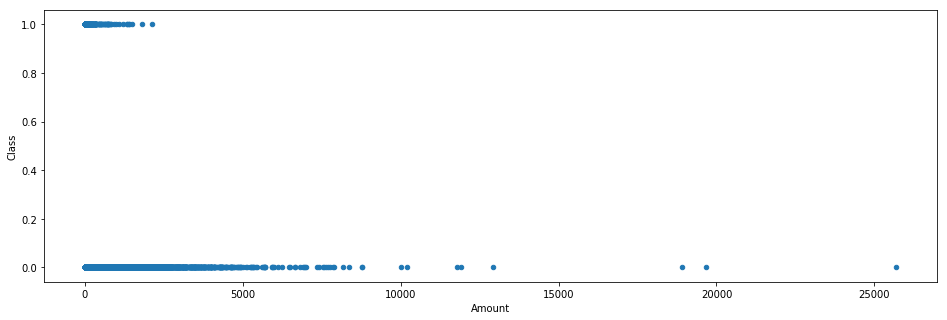

In [10]:
#Is there an apparent direct relation between _Amount_ and target _Class_?
fraud_data.plot(kind='scatter',x='Amount',y='Class',figsize=(16, 5))

In [11]:
fraud_data['Amount'][fraud_data['Class'] == 1].max()

2125.87

Except that there are no frauds with values above 2125.87 (which may be coincidence), there seems to be no direct univariate correlation between _Amount_ and target _Class_.

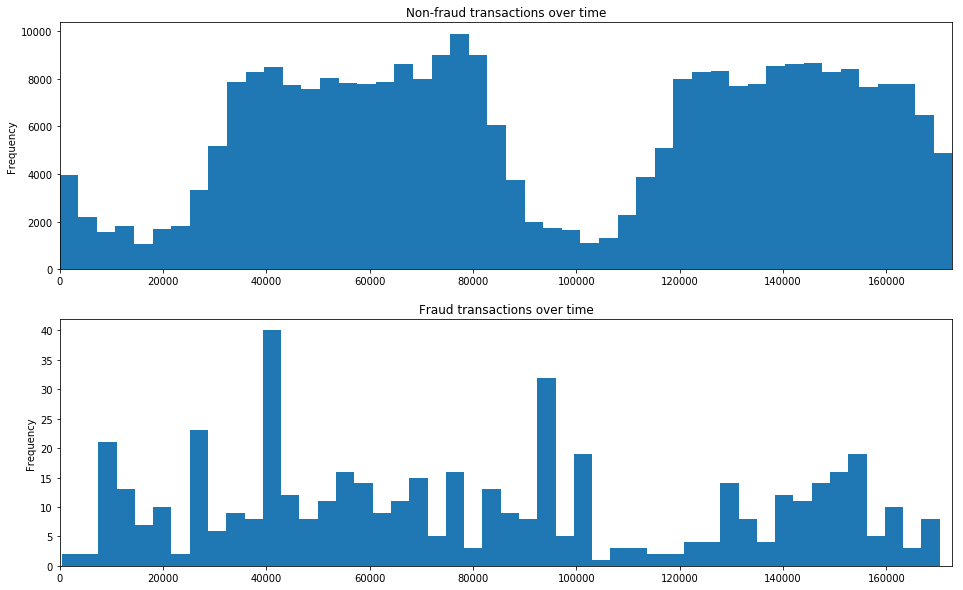

In [12]:
#Are frauds more concentrated in a certain period of the day?
fig, axes = plt.subplots(nrows=2, ncols=1)
fraud_data['Time'][fraud_data['Class']==0].plot(kind='hist', figsize=(16, 10), title='Non-fraud transactions over time',
                                                ax=axes[0], bins=48,xlim=(fraud_data['Time'].min(),fraud_data['Time'].max()))
fraud_data['Time'][fraud_data['Class']==1].plot(kind='hist', figsize=(16, 10), title='Fraud transactions over time',
                                                ax=axes[1], bins=48,xlim=(fraud_data['Time'].min(),fraud_data['Time'].max()))

There appears to be unusual fraud activity in the periods where legitimate transactions present higher volume. Binning the _Time_ data into sections of the day may therefore provide a very relevant feature!

## Feature engineering

In [13]:
original_features = fraud_data.columns[1:29]
work_data = fraud_data[original_features].copy()

In [14]:
#Scale _Amount_ feature
work_data['V29'] = preprocessing.scale(fraud_data['Amount'])

In [15]:
time = pandas.DataFrame()
time['time'] = fraud_data['Time']
time['time_in_hours'] = (time['time']/3600).astype(int)
time['day'] = (time['time_in_hours'] / 24).astype(int)
time['time_of_day'] = time['time_in_hours'] - 24*time['day']

time['time_of_day'].value_counts(sort=False)

0      7695
1      4220
2      3328
3      3492
4      2209
5      2990
6      4101
7      7243
8     10276
9     15838
10    16598
11    16856
12    15420
13    15365
14    16570
15    16461
16    16453
17    16166
18    17039
19    15649
20    16756
21    17703
22    15441
23    10938
Name: time_of_day, dtype: int64

Instead of using this feature as it is, regression models may benefit from having a feature centered around the period of highest activity, with the lowest activity at the extremes. As the lowest activity occurs between 4:00 and 5:00, we'll center the new feature at the value of 16 (12 being the _natural_ center, plus the 4 hours to match the lowest activity).

In [16]:
time['distance_to_16'] = time['time_of_day'] - 16 + 24*(time['time_of_day']<4)

In [17]:
#Add feature for time of day
work_data['V30'] = preprocessing.scale(time['distance_to_16'].astype(float))

In [18]:
##Add target
work_data['target'] = fraud_data['Class'].copy()

In [19]:
work_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,target
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,1.563225,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,1.563225,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,1.563225,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,1.563225,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,1.563225,0


## Dataset preparation

In [20]:
#Split indexes into train and test
(train_index, test_index) = cross.train_test_split(work_data.index,test_size = TEST_SPLIT, random_state = RANDOM_SEED)

train_data = work_data.iloc[train_index]
test_data = work_data.iloc[test_index]

train_data.reset_index(inplace = True, drop = True)
test_data.reset_index(inplace = True, drop = True)

features = work_data.columns[0:30]

## Models training

Leveraging Scikit-Learn to train different models on our work_data

#### Logistic regression

In [21]:
tune_parameters = {'C':[0.01,0.03,0.1,0.3,1,3,10,30,100]}
model_logit = LogisticRegression(tol=TOL, max_iter=MAX_ITER,
                                 class_weight='balanced', random_state=RANDOM_SEED,
                                 verbose=1) 
cross_validation_logit = GridSearchCV(model_logit, tune_parameters, scoring='f1',
                                      return_train_score=True)
cross_validation_logit.fit(train_data[features], numpy.ravel(train_data['target']))
cross_validation_logit.cv_results_

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

{'mean_fit_time': array([4.48614915, 5.00676004, 5.15833902, 6.07352034, 5.44999305,
        5.54070719, 5.09351055, 5.43712815, 5.49008481]),
 'mean_score_time': array([0.02754251, 0.02451785, 0.03553303, 0.02685428, 0.02085002,
        0.02219081, 0.02202137, 0.02001564, 0.02201478]),
 'mean_test_score': array([0.1149887 , 0.11471996, 0.11282244, 0.11211998, 0.11186331,
        0.11158482, 0.1114928 , 0.11145792, 0.11145792]),
 'mean_train_score': array([0.12005225, 0.11790913, 0.11704475, 0.1161406 , 0.1157971 ,
        0.11562206, 0.11554704, 0.11555337, 0.11555352]),
 'param_C': masked_array(data=[0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.01},
  {'C': 0.03},
  {'C': 0.1},
  {'C': 0.3},
  {'C': 1},
  {'C': 3},
  {'C': 10},
  {'C': 30},
  {'C': 100}],
 'rank_test_score': array([1, 2, 3, 4, 5, 6, 7, 8, 8]),
 's

In [22]:
#From the results above
model_logit.set_params(C=0.01) 
model_logit.fit(train_data[features], numpy.ravel(train_data['target']))

[LibLinear]

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100000.0,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=1e-05, verbose=1, warm_start=False)

#### Decision Tree

In [23]:
tune_parameters = {'criterion':['gini','entropy']}
model_tree = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_SEED)
cross_validation_tree = GridSearchCV(model_tree, tune_parameters, scoring='f1',
                                     return_train_score=True)
cross_validation_tree.fit(train_data[features], numpy.ravel(train_data['target']))
cross_validation_tree.cv_results_

{'mean_fit_time': array([5.52715143, 5.90185674]),
 'mean_score_time': array([0.02971331, 0.0298926 ]),
 'mean_test_score': array([0.69849578, 0.766285  ]),
 'mean_train_score': array([1., 1.]),
 'param_criterion': masked_array(data=['gini', 'entropy'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'gini'}, {'criterion': 'entropy'}],
 'rank_test_score': array([2, 1]),
 'split0_test_score': array([0.68548387, 0.79230769]),
 'split0_train_score': array([1., 1.]),
 'split1_test_score': array([0.68273092, 0.74897119]),
 'split1_train_score': array([1., 1.]),
 'split2_test_score': array([0.72727273, 0.75757576]),
 'split2_train_score': array([1., 1.]),
 'std_fit_time': array([0.83603322, 0.45575376]),
 'std_score_time': array([0.0004902 , 0.00062418]),
 'std_test_score': array([0.02037932, 0.01873325]),
 'std_train_score': array([0., 0.])}

In [24]:
model_tree.set_params(criterion='entropy')
model_tree.fit(train_data[features], numpy.ravel(train_data['target']))

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

#### Random Forest model

In [25]:
tune_parameters = {'criterion':['gini','entropy']}
model_forest = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_SEED,
                                      verbose=1)
cross_validation_forest = GridSearchCV(model_forest, tune_parameters, scoring='f1',
                                       return_train_score=True)
cross_validation_forest.fit(train_data[features], numpy.ravel(train_data['target']))
cross_validation_forest.cv_results_

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.3s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

{'mean_fit_time': array([6.58769051, 8.1818525 ]),
 'mean_score_time': array([0.11989721, 0.1092569 ]),
 'mean_test_score': array([0.81404801, 0.8229884 ]),
 'mean_train_score': array([0.97594743, 0.97462782]),
 'param_criterion': masked_array(data=['gini', 'entropy'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'gini'}, {'criterion': 'entropy'}],
 'rank_test_score': array([2, 1]),
 'split0_test_score': array([0.81385281, 0.8       ]),
 'split0_train_score': array([0.97465887, 0.97064579]),
 'split1_test_score': array([0.78181818, 0.81896552]),
 'split1_train_score': array([0.98455598, 0.98259188]),
 'split2_test_score': array([0.84647303, 0.85      ]),
 'split2_train_score': array([0.96862745, 0.97064579]),
 'std_fit_time': array([0.30297645, 0.21147704]),
 'std_score_time': array([0.01671004, 0.00086323]),
 'std_test_score': array([0.02639553, 0.02060969]),
 'std_train_score': array([0.00656632, 0.00563144])}

In [26]:
#Random forest model
model_forest.set_params(criterion='entropy')
model_forest.fit(train_data[features], numpy.ravel(train_data['target']))

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.8s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)

#### XG Boost

In [27]:
tune_parameters = {'n_estimators':[10,100,300],'subsample':[0.1,0.5,1.0]}
model_xgboost = GradientBoostingClassifier(random_state=RANDOM_SEED,
                                           verbose=1)
cross_validation_xg = GridSearchCV(model_xgboost, tune_parameters, scoring='f1',
                                   return_train_score=True)
cross_validation_xg.fit(train_data[features], numpy.ravel(train_data['target']))
cross_validation_xg.cv_results_

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0079          -0.0180            1.70s
         2           0.0180          -0.0011            1.66s
         3           0.0385           0.0005            1.38s
         4           0.0417          -0.0227            1.22s
         5           0.0887          -0.0032            0.99s
         6           0.0397          -0.5795            0.79s
         7           0.0416          -0.0073            0.57s
         8           0.0328           0.0001            0.38s
         9           0.0439           0.0001            0.19s
        10           0.0318           0.0001            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0141          -0.0186            1.61s
         2           0.0279          -0.0025            1.63s
         3           0.0397          -0.0152            1.43s
         4           0.0211          -0.0063            1.26s
      

        90 1665661249837619612823472600681119666858304134340694697470508070518397155127738088526967465687631569064125208334377642140519455423638896902144.0000           0.0000            2.26s
       100 2319758536476670239446446336626340090088889811372200548124680790136226411231808446217916156642253993473090490904617116295028878255150751285248.0000           0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0141          -0.0186           19.12s
         2           0.0279          -0.0025           21.58s
         3           0.0397          -0.0152           21.87s
         4           0.0211          -0.0063           22.20s
         5           0.0858          -0.0055           21.63s
         6           0.0559          -0.0236           21.42s
         7           0.0537           0.0160           22.77s
         8           0.0159           0.0003           22.26s
         9           0.0526 -823580117361.5192         

         5 1651716733278434523529762297147929449621460556757575700566501544360664720613899934342299193661059357802106411067165064721714374371669997936181248.0000            1.32m
         6 1651716733278434523529762297147929449621460556757575700566501544360664720613899934342299193661059357802106411067165064721714374371669997936181248.0000            1.32m
         7 1651716733278434523529762297147929449621460556757575700566501544360664720613899934342299193661059357802106411067165064721714374371669997936181248.0000            1.29m
         8 1651716733278434523529762297147929449621460556757575700566501544360664720613899934342299193661059357802106411067165064721714374371669997936181248.0000            1.29m
         9 1651716733278434523529762297147929449621460556757575700566501544360664720613899934342299193661059357802106411067165064721714374371669997936181248.0000            1.31m
        10 1651716733278434523529762297147929449621460556757575700566501544360664720613899934342299193661

        40 593388265378.4281           0.0000           44.10s
        50 889891152927.7158           0.0000           42.41s
        60 818490011940491.1250        -210.1094           40.00s
        70 410283107951036.6250           0.0000           38.02s
        80 888907574127.0002           0.0000           36.04s
        90 409096843096781.7500           0.0000           34.14s
       100 408800696973840.9375           0.0000           33.23s
       200 1185582315403.5559           0.0000           16.34s
       300 313370011724757184034955904221965516275712.0000           0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0150          -0.0328           53.41s
         2           0.0308           0.0015           53.83s
         3           0.0416           0.0009           51.71s
         4           0.0153     -447153.6165           53.99s
         5     1341529.6013          -0.0324           51.93s
         6      6

         5 1651716733278434523529762297147929449621460556757575700566501544360664720613899934342299193661059357802106411067165064721714374371669997936181248.0000            3.70m
         6 1651716733278434523529762297147929449621460556757575700566501544360664720613899934342299193661059357802106411067165064721714374371669997936181248.0000            3.68m
         7 1651716733278434523529762297147929449621460556757575700566501544360664720613899934342299193661059357802106411067165064721714374371669997936181248.0000            3.67m
         8 1651716733278434523529762297147929449621460556757575700566501544360664720613899934342299193661059357802106411067165064721714374371669997936181248.0000            3.66m
         9 1651716733278434523529762297147929449621460556757575700566501544360664720613899934342299193661059357802106411067165064721714374371669997936181248.0000            3.65m
        10 1651716733278434523529762297147929449621460556757575700566501544360664720613899934342299193661

{'mean_fit_time': array([  2.73674631,   6.20925864,   7.82690843,  21.6672256 ,
         56.71091096,  68.67120298,  53.22796535, 165.49380612,
        235.57134604]),
 'mean_score_time': array([0.047417  , 0.04405522, 0.04205592, 0.13080192, 0.16318274,
        0.11625361, 0.29838339, 0.49118328, 0.42548052]),
 'mean_test_score': array([0.67375892, 0.76436032, 0.76614529, 0.37471048, 0.65709685,
        0.73159949, 0.34861157, 0.56933432, 0.73159949]),
 'mean_train_score': array([0.7260955 , 0.81966826, 0.83217915, 0.4239723 , 0.69357835,
        0.79242316, 0.40019191, 0.65217651, 0.79242316]),
 'param_n_estimators': masked_array(data=[10, 10, 10, 100, 100, 100, 300, 300, 300],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_subsample': masked_array(data=[0.1, 0.5, 1.0, 0.1, 0.5, 1.0, 0.1, 0.5, 1.0],
              mask=[False, False, False, False, False, False, False, 

In [28]:
#XG Boost model
model_xgboost.set_params(n_estimators=10,subsample=1)
model_xgboost.fit(train_data[features], numpy.ravel(train_data['target']))

      Iter       Train Loss   Remaining Time 
         1           0.0282           12.69s
         2           0.1214           11.25s
         3 73335210681972299754644038225950581482262814337226631946193043571940601583090568169157709761426900290477012025344.0000            9.72s
         4 73335210681972299754644038225950581482262814337226631946193043571940601583090568169157709761426900290477012025344.0000            8.28s
         5 73335210681972299754644038225950581482262814337226631946193043571940601583090568169157709761426900290477012025344.0000            6.88s
         6 73335210681972299754644038225950581482262814337226631946193043571940601583090568169157709761426900290477012025344.0000            5.50s
         7 73335210681972299754644038225950581482262814337226631946193043571940601583090568169157709761426900290477012025344.0000            4.09s
         8 73335210681972299754644038225950581482262814337226631946193043571940601583090568169157709761426900290477012025344.0000

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=42, subsample=1, verbose=1,
              warm_start=False)

#### ADA Boost

In [29]:
tune_parameters = {'n_estimators':[10,50,100]}
model_adaboost = AdaBoostClassifier(random_state=RANDOM_SEED)
cross_validation_ada = GridSearchCV(model_adaboost, tune_parameters, scoring='f1',
                                    return_train_score=True)
cross_validation_ada.fit(train_data[features], numpy.ravel(train_data['target']))
cross_validation_ada.cv_results_

{'mean_fit_time': array([ 8.34121529, 44.46844323, 96.47816364]),
 'mean_score_time': array([0.18563946, 0.67252318, 1.6052045 ]),
 'mean_test_score': array([0.71855472, 0.7292284 , 0.78590344]),
 'mean_train_score': array([0.72714213, 0.76676704, 0.83919882]),
 'param_n_estimators': masked_array(data=[10, 50, 100],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 10}, {'n_estimators': 50}, {'n_estimators': 100}],
 'rank_test_score': array([3, 2, 1]),
 'split0_test_score': array([0.72413793, 0.73593074, 0.76987448]),
 'split0_train_score': array([0.70912951, 0.788     , 0.85539715]),
 'split1_test_score': array([0.68444444, 0.70175439, 0.76855895]),
 'split1_train_score': array([0.76091476, 0.76386037, 0.82886598]),
 'split2_test_score': array([0.74708171, 0.75      , 0.81927711]),
 'split2_train_score': array([0.71138211, 0.74844075, 0.83333333]),
 'std_fit_time': array([0.09617005, 4.1349556 , 4.83171043]),
 's

In [30]:
#ADA Boost
model_adaboost.set_params(n_estimators=100)
model_adaboost.fit(train_data[features], numpy.ravel(train_data['target']))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=42)

#### SVM

In [31]:
tune_parameters = {'C':[0.01,0.1,1,10,100]}
model_svm = svm.SVC(tol=TOL, max_iter=MAX_ITER,
                    class_weight='balanced', random_state=RANDOM_SEED,
                    verbose=1)
cross_validation_svm = GridSearchCV(model_svm, tune_parameters, scoring='f1',
                                    return_train_score=True)
cross_validation_svm.fit(train_data[features], numpy.ravel(train_data['target']))
cross_validation_svm.cv_results_

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

{'mean_fit_time': array([535.18364429, 260.00802811,  70.63072554,  43.07608994,
         27.16431832]),
 'mean_score_time': array([106.96973435,  42.10134268,  15.67503866,   6.72432661,
          3.33342385]),
 'mean_test_score': array([0.11983713, 0.27884624, 0.48041886, 0.63500881, 0.67997917]),
 'mean_train_score': array([0.12772783, 0.36230768, 0.65120369, 0.87165271, 0.96930439]),
 'param_C': masked_array(data=[0.01, 0.1, 1, 10, 100],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}],
 'rank_test_score': array([5, 4, 3, 2, 1]),
 'split0_test_score': array([0.12645591, 0.32312925, 0.50837989, 0.61090909, 0.65354331]),
 'split0_train_score': array([0.14196833, 0.45749343, 0.7100271 , 0.91130435, 0.97761194]),
 'split1_test_score': array([0.13264723, 0.26812585, 0.44444444, 0.61029412, 0.65306122]),
 'split1_train_score': array([0.13721186, 0.34025974, 0.6

In [32]:
model_svm.set_params(C=100)
model_svm.fit(train_data[features], numpy.ravel(train_data['target']))

[LibSVM]

SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=100000.0, probability=False, random_state=42, shrinking=True,
  tol=1e-05, verbose=1)

## Models comparison

Now that we have a tuned version of each model, we can compare them to determine which one works best, that is, which one generalizes best on the test data set.

In [33]:
predict_logit = model_logit.predict(test_data[features])
predict_tree = model_tree.predict(test_data[features])
predict_forest = model_forest.predict(test_data[features])
predict_xgboost = model_xgboost.predict(test_data[features])
predict_adaboost = model_adaboost.predict(test_data[features])
predict_svm = model_svm.predict(test_data[features])

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [34]:
#Precision and recall
print('model                      precision |  recall  |    F1')
print('Logistic regression          {:.4f}  |  {:.4f}  |  {:.4f}'.format(
      metrics.precision_score(predict_logit,numpy.ravel(test_data['target'])),
      metrics.recall_score(predict_logit,numpy.ravel(test_data['target'])),
      metrics.f1_score(predict_logit,numpy.ravel(test_data['target']))))
print('Decision Tree                {:.4f}  |  {:.4f}  |  {:.4f}'.format(
      metrics.precision_score(predict_tree,numpy.ravel(test_data['target'])),
      metrics.recall_score(predict_tree,numpy.ravel(test_data['target'])),
      metrics.f1_score(predict_tree,numpy.ravel(test_data['target']))))
print('Random Forest                {:.4f}  |  {:.4f}  |  {:.4f}'.format(
      metrics.precision_score(predict_forest,numpy.ravel(test_data['target'])),
      metrics.recall_score(predict_forest,numpy.ravel(test_data['target'])),
      metrics.f1_score(predict_forest,numpy.ravel(test_data['target']))))
print('XG Boost                     {:.4f}  |  {:.4f}  |  {:.4f}'.format(
      metrics.precision_score(predict_xgboost,numpy.ravel(test_data['target'])),
      metrics.recall_score(predict_xgboost,numpy.ravel(test_data['target'])),
      metrics.f1_score(predict_xgboost,numpy.ravel(test_data['target']))))
print('ADA Boost                    {:.4f}  |  {:.4f}  |  {:.4f}'.format(
      metrics.precision_score(predict_adaboost,numpy.ravel(test_data['target'])),
      metrics.recall_score(predict_adaboost,numpy.ravel(test_data['target'])),
      metrics.f1_score(predict_adaboost,numpy.ravel(test_data['target']))))
print('SVM                          {:.4f}  |  {:.4f}  |  {:.4f}'.format(
      metrics.precision_score(predict_svm,numpy.ravel(test_data['target'])),
      metrics.recall_score(predict_svm,numpy.ravel(test_data['target'])),
      metrics.f1_score(predict_svm,numpy.ravel(test_data['target']))))

model                      precision |  recall  |    F1
Logistic regression          0.9184  |  0.0637  |  0.1192
Decision Tree                0.7449  |  0.8022  |  0.7725
Random Forest                0.7245  |  0.9726  |  0.8304
XG Boost                     0.6837  |  0.7283  |  0.7053
ADA Boost                    0.7347  |  0.8675  |  0.7956
SVM                          0.6837  |  0.7614  |  0.7204


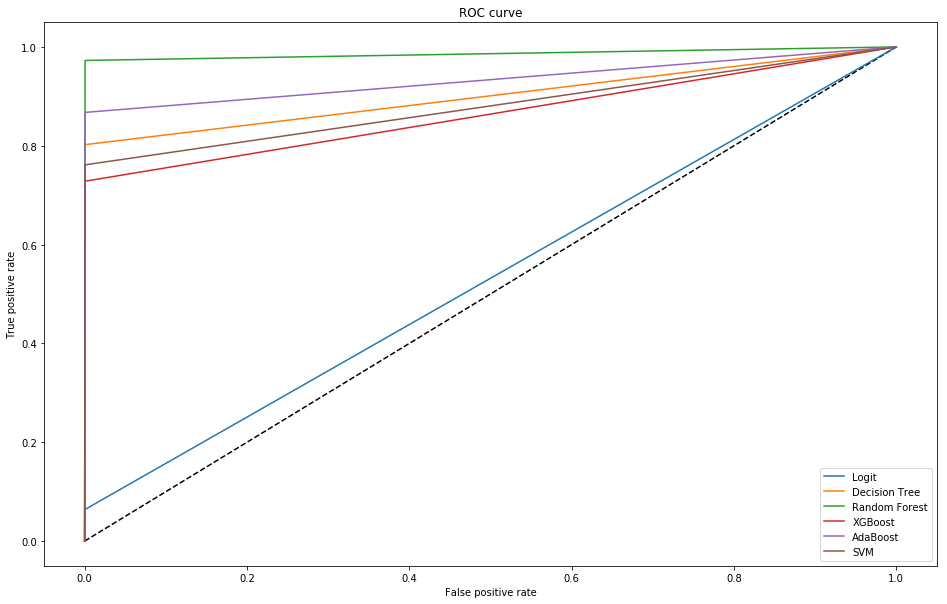

In [35]:
# ROC curves
# fpr_logit, tpr_logit, _ = metrics.roc_curve(numpy.ravel(test_data['target']), predict_logit)
# fpr_tree, tpr_tree, _ = metrics.roc_curve(numpy.ravel(test_data['target']), predict_tree)
# fpr_forest, tpr_forest, _ = metrics.roc_curve(numpy.ravel(test_data['target']), predict_forest)
# fpr_xgboost, tpr_xgboost, _ = metrics.roc_curve(numpy.ravel(test_data['target']), predict_xgboost)
# fpr_adaboost, tpr_adaboost, _ = metrics.roc_curve(numpy.ravel(test_data['target']), predict_adaboost)
# fpr_svm, tpr_svm, _ = metrics.roc_curve(numpy.ravel(test_data['target']), predict_svm)

fpr_logit, tpr_logit, _ = metrics.roc_curve(predict_logit, numpy.ravel(test_data['target']))
fpr_tree, tpr_tree, _ = metrics.roc_curve(predict_tree, numpy.ravel(test_data['target']))
fpr_forest, tpr_forest, _ = metrics.roc_curve(predict_forest, numpy.ravel(test_data['target']))
fpr_xgboost, tpr_xgboost, _ = metrics.roc_curve(predict_xgboost, numpy.ravel(test_data['target']))
fpr_adaboost, tpr_adaboost, _ = metrics.roc_curve(predict_adaboost, numpy.ravel(test_data['target']))
fpr_svm, tpr_svm, _ = metrics.roc_curve(predict_svm, numpy.ravel(test_data['target']))

plt.figure(1, figsize=(16, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_logit, tpr_logit, label='Logit')
plt.plot(fpr_tree, tpr_tree, label='Decision Tree')
plt.plot(fpr_forest, tpr_forest, label='Random Forest')
plt.plot(fpr_xgboost, tpr_xgboost, label='XGBoost')
plt.plot(fpr_adaboost, tpr_adaboost, label='AdaBoost')
plt.plot(fpr_svm, tpr_svm, label='SVM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

The results above show clear superior predictive power on the **Random Forest** when compared to the other models tested.

In cases of fraud detection, it is reasonable to assume that the predictive model will be used to trigger further action against the attempted fraud, such as additional validation before completing the transaction. Therefore a high **recall** metric is especially relevant, meaning that a higher number of frauds will be sent to additional validation, albeit at the cost of sending more legitimate transactions the same way. This is certainly better than _bothering_ fewer legitimate customers at the expense of letting more frauds through.

The **Random Forest** model performs exceptionally well in this metric, detecting more than 97% fraud cases on the generalization test, with precision significantly close to all other models except Logistic Regression (which fails miserably at recall, detecting only 6% of the actual fraud cases).


As a final analysis, let's see how the newly engineered features affected our models:

In [36]:
model_logit.coef_

array([[ 0.39486226,  0.00637974,  0.17415135,  0.84874589,  0.31576623,
        -0.28480923, -0.19340365, -0.42736045, -0.45534436, -0.884398  ,
         0.385547  , -0.9442033 , -0.15534971, -1.14881111, -0.13196692,
        -0.54985644, -0.5184723 , -0.21033853,  0.17382833, -0.52922338,
         0.1977625 ,  0.53760502, -0.07447851, -0.13076075,  0.01858075,
        -0.43359303,  0.08325824,  0.44777951,  0.78401455,  0.08538628]])

The Logistic Regression model was significantly impacted by the _Amount_ (V29 being among top 5 most relevant features), but not by the _Time of day_ (V30, the last one, ranking on bottom 5). Note: _Time_ may have been affected by the low regularization parameter selected on tuning, but a higher parameter wouldn't change its position relative to other features.

In [37]:
model_tree.feature_importances_

array([3.79740836e-03, 1.85646275e-02, 4.67477516e-03, 6.10494475e-02,
       3.59989579e-03, 3.44854106e-03, 4.24564250e-03, 1.58457107e-02,
       7.76506066e-03, 4.87266073e-03, 2.63692157e-03, 4.43741313e-02,
       6.44181925e-03, 6.83411001e-01, 1.00888101e-02, 2.66567217e-03,
       6.80448737e-03, 3.94414271e-03, 2.29520902e-02, 2.49829550e-04,
       6.11889843e-05, 3.98850603e-03, 1.69340783e-02, 1.79896363e-03,
       1.10307554e-03, 1.81455522e-02, 1.69423371e-02, 1.93120804e-03,
       2.61634316e-02, 1.49898354e-03])

The Decision Tree behaved similarly with these two variables: _Amount_ is still top 5, and _Time_ is still bottom 5.

In [38]:
model_forest.feature_importances_

array([0.01053937, 0.00797883, 0.05771089, 0.10647687, 0.00932646,
       0.00708323, 0.05788485, 0.01883541, 0.00487664, 0.05045152,
       0.0721503 , 0.02180669, 0.01107454, 0.30717858, 0.00642483,
       0.06004379, 0.08009896, 0.00901563, 0.01742218, 0.00456321,
       0.00934209, 0.01017223, 0.00815084, 0.00864613, 0.00942504,
       0.01159949, 0.00573452, 0.00485479, 0.00798205, 0.00315005])

The best performing model, the Random Forest, had a much lower ranking for _Amount_, while _Time_ was the least relevant feature used.

## Unsupervised next steps

This challenge could be attacked as an anomaly detection problem - the fraud attempts being anomalous transactions in the population. One popular model for such approach would be k-NN, which clusters samples together based on each samples' nearest neighbours. A large distance to its neighbours may be a good indication that a given sample is an outlier.